# WALLABY user science notebook

In this notebook we will provide some example scripts for doing science in this Python notebook environment on the WALLABY data. We will go through the following:

1. Initialise Django
2. View sources and their properties
3. Data analysis - plotting HI mass against redshift
4. Selecting subsets
5. Plotting source products

## 1. Initialise Django

The following cells must be run first. They are used to import `django`, set up a connection to the database and import the Django models. Once these cells are run, you are able to use the Django model objects for access to the database.

In [ ]:
# Essential Python libraries for using the ORM

import sys
import os
import django

In [ ]:
# We will provide a plotting script that actually doesn't make use of the products retrieved above. Instead, just provide the detection and they will be retrieved in the function below.

import io
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from django.db import models
from django.forms.models import model_to_dict

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval
from astroquery.skyview import SkyView
from astropy.utils.data import clear_download_cache
from astropy.cosmology import Planck15 as cosmo

from astropy.table import Table

In [ ]:
# Database access environment variables

os.environ["DJANGO_SECRET_KEY"] = "-=(gyah-@e$-ymbz02mhwu6461zv&1&8uojya413ylk!#bwa-l"
os.environ["DJANGO_SETTINGS_MODULE"] = "api.settings"
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "True"
os.environ["DATABASE_HOST"] = "146.118.67.204"
os.environ["DATABASE_NAME"] = "wallabydb"
os.environ["DATABASE_USER"] = "wallaby_user"
os.environ["DATABASE_PASSWORD"] = "LKaRsQrNtXZ7vN8L*6"

In [ ]:
# Connect with SoFiAX_services Django ORM

sys.path.append('/mnt/shared/wallaby/apps/SoFiAX_services/api/')
django.setup()

In [ ]:
# Import models

from tables.models import Run, Instance, Detection, Product, Source, SourceDetection

## Setup

The intention of this notebook is to demonstrate to WALLABY science users that it is possible to use this environment to access the data and perform analysis with Python using libraries that you are familiar with. To do this, we provide some simple analysis examples and plotting tools to show how this can be done.

To start, we will select just a subset of the data. Let's take all of the data for a given run (region of sky) and just work with the sources there. In the two cells below, the first will show you all of the runs in the database, and in the second we select a run to work with for the rest of the notebook.

In [ ]:
# List all runs in the database

Run.objects.all()

In [ ]:
# Set run name

# run_name = 'NGC4636_DR1'
run_name = "NGC5044_4"

## 2. View source and their properties

You will want to work with the source and detection tables primarily, as they represent the WALLABY catalogue. Here we will show you how to access the sources and their properties through the Django ORM.

### Table names and descriptions

- source: WALLABY source as determined by the science team. References a detection.
- detection: WALLABY detection with properties generated by the source finding application.
- run: Observation region from which sources and detections are extracted. 
- products: Moment maps, spectra, and other figures associated with a detection.

### Table structure

First, it is important to understand how these sources and detections are stored in the database. This will determine the access pattern that you will use to get catalogue information. The diagram below shows the relationship between the run and sources tables. You can see that there is an intermediate source_detection table that is used to map a source and a detection, and that there is a relationship between the detection and run. 

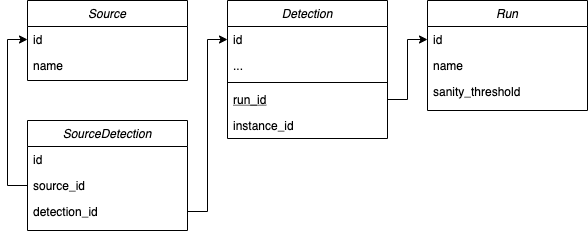

### Query result

Django models provide an object-relational mapper to work with database tables as if they were Python objects. We'll provide a few examples for how to get objects from the database, but for a more comprehensive guide you can look at the documentation [here](https://docs.djangoproject.com/en/3.2/topics/db/queries/#retrieving-objects).

To get a list of the sources we will need to decide which run we are interested in. This run is the region of sky. We can query the database to look the runs that are in the database. With Django, the rows of the database are retrieved in the form of Django objects called [QuerySets](https://docs.djangoproject.com/en/3.2/ref/models/querysets/). We can essentially treat them as lists (and can be converted directly to a native Python list with `list()` on the object).

So, started from the run we must do the following to get access to the sources using foreign key relationships:

1. View Source and Detection properties
2. Get Detections of interest in a Run
3. Get SourceDetection map from Detections
4. Get Sources from SourceDetection source_id field

It's probably not useful to just be able to see the names of the sources. We want to look at the source properties obtained from the source finding application, or at the data products associated with it. To start to access these we first need to know the structure of the tables of interest. Let's look at the schema for the two tables in the cells below.

In [ ]:
# 1. Source table properties

Source._meta.fields

In [ ]:
# 1. Detection table properties

Detection._meta.fields

In [ ]:
# 2. Get detections of interest in a run

detections = Detection.objects.filter(run_id = Run.objects.get(name=run_name))

In [ ]:
# 3. Get the source_detection map for detections to get the source ids

detections_to_sources = SourceDetection.objects.filter(detection_id__in=[d.id for d in detections])

In [ ]:
# 4. Get the sources from the source_detection ids

sources = Source.objects.filter(id__in=[d.source_id for d in detections_to_sources])
print([s.name for s in sources])

Sure that was probably fine but it will probably be more useful to have a function that will allow us to get the detection corresponding to any source. Given how these tables are structured we also need the run to get a specific detection. We'll include this function below for you.

In [ ]:
# Functions for getting the properties of a source

def get_detection(source_name, run_name):
    """Get the detection for a given source and run.
    
    """
    run = Run.objects.get(name=run_name)
    source = Source.objects.get(name=source_name)
    detection_ids = [sd.detection_id for sd in SourceDetection.objects.filter(source_id=source.id)]
    
    # where there is only 1 detection     
    if (len(detection_ids) == 1):
        detection = Detection.objects.get(id=detection_ids[0])
        return detection

    # Need to specify the run
    detection = Detection.objects.filter(id__in=detection_ids).filter(run_id=run.id).first()
    return detection

Great! Now we have access to all of the sources for a run.

## 3. Data Analysis - plotting HI mass against redshift

We will provide an example of a simple analysis that can be done in this notebook using the WALLABY data. Here, we're going to compare the HI mass of the sources in a run with their redshift. In this example we show how you can retrieve and use properties of each of the sources, compute new properties and visualise them.

We will store the data for a given run in an `astropy` table object. This allows us to interact with the database table in a convenient way, with each of the columns as vectors.

In [ ]:
# Get detections and sources as an Astropy table

def create_astropy_table(run_name):
    t = Table()
    
    # get field names
    detection_field_names = [field.name for field in Detection._meta.fields if field.name != 'id' and not isinstance(field, models.ForeignKey)]
    detection_field_names.remove('name')    
    source_field_names = [field.name for field in Source._meta.fields if not isinstance(field, models.ForeignKey)]
    
    # get sources and detections    
    detections = Detection.objects.filter(run_id = Run.objects.get(name=run_name))
    detections_to_sources = SourceDetection.objects.filter(detection_id__in=[d.id for d in detections])
    detections = [Detection.objects.get(id=d.detection_id) for d in detections_to_sources]
    sources = Source.objects.filter(id__in=[d.source_id for d in detections_to_sources])
    
    # add columns to the table
    for field in detection_field_names:
        t[field] = [getattr(d, field) for d in detections]
    for field in source_field_names:
        t[field] = [getattr(s, field) for s in sources]

    return t

In [ ]:
# Create the table

table = create_astropy_table(run_name)
print(table)

In [ ]:
# Get properties for each of the sources from their corresponding detection

freq = table['freq']
f_sum = table['f_sum']

In [ ]:
# Get redshift for each of the sources

def calculate_redshift(frequency):
    rest = 1420.406 * float(10**6)
    return (rest / frequency - 1.0)

z = calculate_redshift(freq)

In [ ]:
# HI mass

def calculate_HI_mass(z, flux):
    luminosity_distance = cosmo.luminosity_distance(z).value
    return np.log10(49.7 * (luminosity_distance ** 2) * flux)

HI_mass = calculate_HI_mass(z, f_sum)

In [ ]:
# Plot to compare

%matplotlib inline

fig, ax = plt.subplots(dpi=140)
plt.scatter(z, HI_mass, s=10)
plt.ylabel('HI mass')
plt.xlabel('redshift')
plt.show()

## 4. Selecting subsets

We will also provide an example of how to select a subset of the sources. We'll provide two examples to show how this can be done:

1. Select a subset of the sources based on their systemic velocity
2. Select sources based on their position in the sky.

### Filter on systemic velocity

For the sources we have shown above (in the redshift vs HI mass figure) we can perform a filter of the sources based on their velocity, and subsequently their redshift. This is fairly straightforward, requiring only to create a mask on the frequency values in the table.

In [ ]:
# Import constants for mask calculation

from astropy import constants as const

velocity_cut = 7000.0
C_LIGHT = const.c.to('km/s').value
HI_REST = 1420.406 * 10**6
frequency_cut = HI_REST / (velocity_cut / C_LIGHT + 1.0)

In [ ]:
# Mask for table based on filter

mask = [table['freq'] > frequency_cut]

In [ ]:
# Plot to compare

%matplotlib inline

fig, ax = plt.subplots(dpi=140)
plt.scatter(z[mask], HI_mass[mask], s=10)
ax.set_xlim(0,0.09)
ax.set_ylim(7,10.5)
plt.ylabel('HI mass')
plt.xlabel('redshift')
plt.show()

### Sky coordinates

We will also perform a filter of the sources based on their coordinates. We will do this in two parts, first we'll show all of the sources and then filter. Again, we'll plot the sources (scatter of their RA and Dec) to show you this filtering working in practice. 

When filtering sources based on coordinates we can do two things:

- A hard cut in RA and Dec values
- Angular separation within some threshold of a specified RA and Dec.

The latter will require the use of `astropy` for determining the separation of sources between each other. The first step will be the importing of libraries that have not been required earlier.

In [ ]:
# retrieve source positions

names = table['name']
ra = table['ra']
dec = table['dec']

In [ ]:
# Interactive view of the plots
# NOTE: there is code here to display the names of the sources interactively

%matplotlib inline

fig, ax = plt.subplots(dpi=140)
sc = plt.scatter(ra, dec, s=10)

annot = ax.annotate("", xy=(0,0), xytext=(0,0), textcoords="offset points", bbox=dict(boxstyle="round", fc="w"))
annot.set_visible(False)

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()

I will pick a source at random in this image and perform filtering for the sources in the vicinity of that source with the two methods described above. I've selected WALLABY_J124742+035222. This source is located at roughly `(192, 4)` in the figure above. The first and easiest way to do this filtering is to create a mask with the RA and Dec range.

In [ ]:
# Mask of RA and Dec values

dRA = 0.2
dDec = 1.0

mask = ((192 - dRA) < table['ra']) & (table['ra'] < (192 + dRA)) & ((4 - dDec) < table['dec']) & (table['dec'] < (4 + dDec))

In [ ]:
# Visualise subset

%matplotlib inline
fig, ax = plt.subplots(dpi=140)
plt.scatter(table['ra'][mask], table['dec'][mask], s=10)
for i, name in enumerate(table['name'][mask]):
    plt.text(table['ra'][mask][i], table['dec'][mask][i], name.replace("WALLABY_", ""), fontsize=8)
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()

Great that was cool and hopefully very straightforward. Now we can create a more complex mask to perform different types of filters. Let's do that by filtering based on the angular distance to the source that we selected previously. This will require the importing of a few `astropy` libraries.

In [ ]:
# import libraries

import astropy.units as u
from astropy.coordinates import SkyCoord

In [ ]:
# Get the source (same as above)

s = Source.objects.get(name='WALLABY_J124742+035222')
d = get_detection(s.name, run_name)

ra_centre = d.ra
dec_centre = d.dec
centre = SkyCoord(ra_centre * u.deg, dec_centre * u.deg, frame='icrs')

In [ ]:
# Mask based on angular separation threshold (degrees)

threshold = 3

mask = centre.separation(SkyCoord(table['ra'] * u.deg, table['dec'] * u.deg, frame='fk5')).degree < threshold

In [ ]:
# Visualise subset

%matplotlib inline
fig, ax = plt.subplots(dpi=140)
plt.scatter(table['ra'][mask], table['dec'][mask], s=10)
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()

Great that is a useful and convenient method for filtering sources. You can see this working by playing with the `threshold` value in the cell above. While we showed how to do this using the angular separation of the sources in the sky it can be even easier if we want to just perform a selection based on the RA and Dec being in some region of sky.

## 5. Plot source products

We provide summary plots that show the moment 0, moment 1 maps, spectra and optical counterpart in a single figure. An example of such a plot is shown below.

In this subsection we provide some code for creating these summary plots for each of the sources of a given run. Each plot takes a few seconds to generate, so this part may take a few minutes. There are also a lot of warnings in the plotting code so you will have to just ignore those.

In [ ]:
# Import libraries for plotting

import io
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval
from astroquery.skyview import SkyView
from astropy.utils.data import clear_download_cache

def retrieve_dss_image(longitude, latitude, width, height):
    hdulist = SkyView.get_images(position="{}, {}".format(longitude, latitude), survey=["DSS2 Blue"], coordinates="J2000", projection="Tan", pixels="{}, {}".format(str(int(2400 * width)), str(int(2400 * height))), width=width*u.deg, height=height*u.deg);
    return hdulist[0][0]

def plot_source(source_name, run_name, save=False, output_dir=None):
    # Plot figure size    
    dss_image = True
    interval = PercentileInterval(95.0)
    plt.rcParams["figure.figsize"] = (12,12)
    
    # Retrieve products from database
    detection = get_detection(source_name, run_name)
    products = Product.objects.get(detection=detection)
    
    # Open moment 0 image
    with io.BytesIO() as buf:
        buf.write(products.mom0)
        buf.seek(0)
        hdu_mom0 = fits.open(buf)[0]
        wcs = WCS(hdu_mom0.header)
        mom0 = hdu_mom0.data

    # Open moment 1 image
    with io.BytesIO() as buf:
        buf.write(products.mom1)
        buf.seek(0)
        hdu_mom1 = fits.open(buf)[0]
        mom1 = hdu_mom1.data

    with io.BytesIO() as buf:
        buf.write(b''.join(products.spec))
        buf.seek(0)
        spectrum = np.loadtxt(buf, dtype="float", comments="#", unpack=True)

    # Get nx and ny from the detection table
        
    # Extract coordinate information
    nx = hdu_mom0.header["NAXIS1"]
    ny = hdu_mom0.header["NAXIS2"]
    clon, clat = wcs.all_pix2world(nx/2, ny/2, 0)
    tmp1, tmp3 = wcs.all_pix2world(0, ny/2, 0)
    tmp2, tmp4 = wcs.all_pix2world(nx, ny/2, 0)
    width = np.rad2deg(math.acos(math.sin(np.deg2rad(tmp3)) * math.sin(np.deg2rad(tmp4)) + math.cos(np.deg2rad(tmp3)) * math.cos(np.deg2rad(tmp4)) * math.cos(np.deg2rad(tmp1 - tmp2))))
    tmp1, tmp3 = wcs.all_pix2world(nx/2, 0, 0)
    tmp2, tmp4 = wcs.all_pix2world(nx/2, ny, 0)
    height = np.rad2deg(math.acos(math.sin(np.deg2rad(tmp3)) * math.sin(np.deg2rad(tmp4)) + math.cos(np.deg2rad(tmp3)) * math.cos(np.deg2rad(tmp4)) * math.cos(np.deg2rad(tmp1 - tmp2))))
    
    # Download DSS image from SkyView
    try:
        hdu_opt = retrieve_dss_image(clon, clat, width, height)
        wcs_opt = WCS(hdu_opt.header)
    except Exception as e:
        dss_image = False
    
    # Plot moment 0
    ax2 = plt.subplot(2, 2, 1, projection=wcs);
    ax2.imshow(mom0, origin="lower");
    ax2.grid(color="grey", ls="solid");
    ax2.set_xlabel("Right ascension (J2000)");
    ax2.set_ylabel("Declination (J2000)");
    ax2.tick_params(axis="x", which="both", left=False, right=False);
    ax2.tick_params(axis="y", which="both", top=False, bottom=False);
    ax2.set_title("moment 0");
    
    # Add beam size     
    e = Ellipse((5, 5), 5, 5, 0, edgecolor='peru', facecolor='peru');
    ax2.add_patch(e);

    # Plot DSS image with HI contours
    if dss_image:
        bmin, bmax = interval.get_limits(hdu_opt.data);
        ax = plt.subplot(2, 2, 2, projection=wcs_opt);
        ax.imshow(hdu_opt.data, origin="lower");
        ax.contour(hdu_mom0.data, transform=ax.get_transform(wcs), levels=np.logspace(2.0, 5.0, 10), colors="lightgrey", alpha=1.0);
        ax.grid(color="grey", ls="solid");
        ax.set_xlabel("Right ascension (J2000)");
        ax.set_ylabel("Declination (J2000)");
        ax.tick_params(axis="x", which="both", left=False, right=False);
        ax.tick_params(axis="y", which="both", top=False, bottom=False);
        ax.set_title("DSS + moment 0");

    # Plot moment 1
    bmin, bmax = interval.get_limits(mom1);
    ax3 = plt.subplot(2, 2, 3, projection=wcs);
    ax3.imshow(hdu_mom1.data, origin="lower", vmin=bmin, vmax=bmax, cmap=plt.get_cmap("gist_rainbow"));
    ax3.grid(color="grey", ls="solid");
    ax3.set_xlabel("Right ascension (J2000)");
    ax3.set_ylabel("Declination (J2000)");
    ax3.tick_params(axis="x", which="both", left=False, right=False);
    ax3.tick_params(axis="y", which="both", top=False, bottom=False);
    ax3.set_title("moment 1");

    # Plot spectrum
    xaxis = spectrum[1] / 1e+6;
    data  = 1000.0 * np.nan_to_num(spectrum[2]);
    xmin = np.nanmin(xaxis);
    xmax = np.nanmax(xaxis);
    ymin = np.nanmin(data);
    ymax = np.nanmax(data);
    ymin -= 0.1 * (ymax - ymin);
    ymax += 0.1 * (ymax - ymin);
    ax4 = plt.subplot(2, 2, 4);
    ax4.step(xaxis, data, where="mid", color="royalblue");
    ax4.set_xlabel("Frequency (MHz)");
    ax4.set_ylabel("Flux density (mJy)");
    ax4.set_title("spectrum");
    ax4.grid(True);
    ax4.set_xlim([xmin, xmax]);
    ax4.set_ylim([ymin, ymax]);

    plt.suptitle(detection.name.replace("_", " ").replace("-", "−"), fontsize=16);
    if save:
        plt.savefig("%s/%s.png" % (output_dir, source_name))
        plt.close()
    else:
        plt.show();

    # Clean up
    clear_download_cache(pkgname="astroquery");
    clear_download_cache();

In [ ]:
%matplotlib inline

plot_source(source_name="WALLABY_J123244+000656", run_name=run_name)

# That's it!

If you have any thoughts or anything you think we should add to this notebook please contact [austin.shen@csiro.au](mailto:austin.shen@csiro.au)